# Combining Dirichlet and Neumann conditions
Author: Jørgen S. Dokken

Let's return to the Poisson problem from the [Fundamentals chapter](./../chapter1/fundamentals.md) and see how to extend the mathematics and the implementation to handle Dirichlet condition in combination with a Neumann condition.
The domain is still the unit square, but now we set the Dirichlet condition $u=u_D$ at the left and right sides, while the Neumann condition 
$$
-\frac{\partial u}{\partial n}=g
$$
is applied to the  remaining sides $y=0$ and $y=1$.

## The PDE problem
Let $\Lambda_D$ and $\Lambda_N$ denote parts of the boundary $\partial \Omega$ where the Dirichlet and Neumann conditions apply, respectively.
The complete boundary-value problem can be written as

$$
-\nabla^2 u =f \qquad \text{in } \Omega,
$$
$$
u=u_D \qquad\text{on } \Lambda_D,
$$
$$
-\frac{\partial u}{\partial n}=g \qquad \text{on }\Lambda_N
$$

Again, we choose $u=1+x^2+2y^2$ as the exact solution and adjust $f, g,$ and $u_D$ accordingly

$$
f(x,y)=-6,
$$
$$
g(x,y)=\begin{cases}
0, & y=0,\\
-4, & y=1,
\end{cases}
$$
$$
u_D(x,y)=1+x^2+2y^2.
$$

For the ease of programming, we define $g$ as a function over the whole domain $\Omega$ such that $g$ takes on the correct values at $y=0$ and $y=1$. One possible extension is
$$
 g(x,y)=-4y.
$$
## The variational formulation
The first task is to derive the variational formulatin. This time we cannot omit the boundary term arising from integration by parts, because $v$ is only zero on $\Lambda_D$. We have

$$
-\int_\Omega (\nabla^2u)v~\mathrm{d} x = \int_\Omega \nabla u \cdot \nabla v ~\mathrm{d} x - \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s,
$$

and since $v=0$ on $\Lambda_D$,

$$
- \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s= - \int_{\Lambda_N}\frac{\partial u}{\partial n}v~\mathrm{d}s =\int_{\Lambda_N} gv~\mathrm{d}s,
$$

by applying the boundary condition on $\Lambda_N$.
The resulting weak from reads

$$
    \int_\Omega \nabla u \cdot \nabla v~\mathrm{d} x = \int_\Omega fv~\mathrm{d} x - \int_{\Lambda_N}gv~\mathrm{d}s.

$$
Expressing this equation in the standard notation $a(u,v)=L(v)$ is straight-forward with 

$$
    a(u,v) = \int_{\Omega} \nabla u \cdot \nabla v ~\mathrm{d} x,\\
$$
$$
L(v) = \int_{\Omega} fv ~\mathrm{d} x - \int_{\Lambda_N} gv~\mathrm{d} s.
$$

## Implementation
As in the previous example, we define our mesh,function space and bilinear form $a(u,v)$.

In [1]:
import dolfinx
import numpy as np
import ufl

from mpi4py import MPI
from petsc4py import PETSc

mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, 10, 10)
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v))*ufl.dx

Now we get to the Neumann and Dirichlet boundary condition. As previously, we use a Python-function to define the boundary where we should have a Dirichlet condition. Then, with this function, we locate degrees of freedom that fullfils this condition. 

In [2]:
def u_exact(x):
    return 1 + x[0]**2 + 2*x[1]**2

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))

dofs_D = dolfinx.fem.locate_dofs_geometrical(V, boundary_D)
u_bc = dolfinx.Function(V)
u_bc.interpolate(u_exact)
u_bc.vector.ghostUpdate(PETSc.InsertMode.INSERT_VALUES, PETSc.ScatterMode.FORWARD)
bc = dolfinx.DirichletBC(u_bc, dofs_D)

The next step is to define the Neumann condition. We first define $g$ uses `UFL`s `SpatialCoordinate`-function, and then in turn create a boundary integration measure `ds`. As the test function $v$ is zero on the boundary integrals over the Dirichlet boundary dissapears, and wee can integrate `g*v*ds` over the entire boundary.

In [3]:
x = ufl.SpatialCoordinate(mesh)
g = -4 * x[1]
f = dolfinx.Constant(mesh, -6)
L = f * v * ufl.dx - g * v * ufl.ds

We can now assemble and solve the linear system of equations 

In [4]:
problem = dolfinx.fem.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

V2 = dolfinx.FunctionSpace(mesh, ("CG", 2))
uex = dolfinx.Function(V2)
uex.interpolate(u_exact)
uex.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
error_L2 = dolfinx.fem.assemble_scalar((uh - uex)**2 * ufl.dx)
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.compute_point_values()
u_ex_vertex_values = uex.compute_point_values()
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 5.27e-03
Error_max : 7.11e-15


## Visualization
To look at the actual solution, run the script as a python script with `off_screen=True` or as a Jupyter notebook with `off_screen=False`

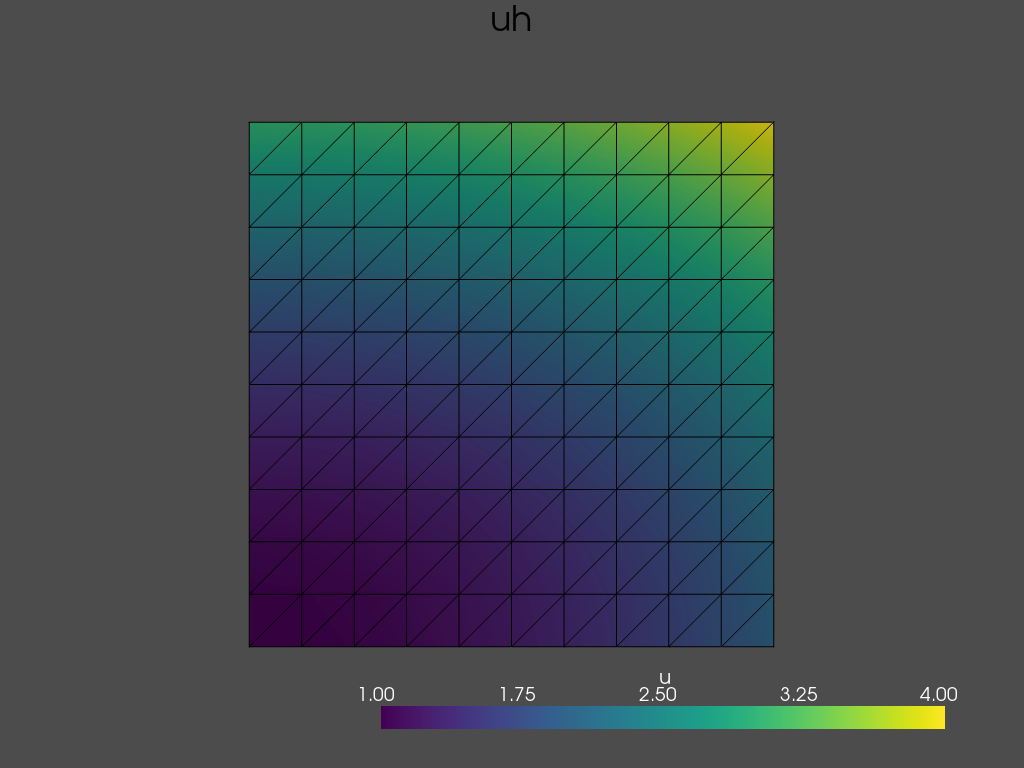

In [5]:
import pyvista
# Start virtual framebuffer
from pyvista.utilities.xvfb import start_xvfb
start_xvfb(wait=0)

import dolfinx.plot
pyvista_cells, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, mesh.geometry.x)
point_values = uh.compute_point_values()
if np.iscomplexobj(point_values):
    point_values = point_values.real
grid.point_arrays["u"] = point_values
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
figure = plotter.screenshot("neumann_dirichlet.png")